In [483]:
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle
import re
import numpy as np
import pandas as pd

with open('evaluation_full.pkl', 'rb') as f:
    df = pickle.load(f)
    
with open('evaluation_roc.pkl', 'rb') as f:
    df_roc = pickle.load(f)

In [484]:
groups = {
    'RF': ['Tf-Idf Embedding Random Forest', 'TinyBert Embedding Random Forest', 
           'Bert Embedding Random Forest', 'Distilbert Embedding Random Forest', 
           'RoBERTa Embedding Random Forest'],
    'SVM': ['Tf-Idf Embedding SVM', 'TinyBert Embedding SVM', 
            'Bert Embedding SVM', 'Distilbert Embedding SVM', 
            'RoBERTa Embedding SVM'],
    'MLP': ['Tf-Idf Embedding Simple NN', 'TinyBert Embedding Simple NN', 
           'Bert Embedding Simple NN', 'Distilbert Embedding Simple NN', 
           'RoBERTa Embedding Simple NN'],
    'LR': ['Tf-Idf Embedding Logistic Regression', 'TinyBert Embedding Logistic Regression', 
           'Bert Embedding Logistic Regression', 'Distilbert Embedding Logistic Regression', 
           'RoBERTa Embedding Logistic Regression'],
    'IF': ['Tf-Idf Outlier generic', 'TinyBert Outlier generic', 
                'Bert Outlier generic', 'Distilbert Outlier generic', 
                'RoBERTa Outlier generic'],
    'Bert': ['Bert Rejector generic'],
    'TBert': ['TinyBert Rejector generic'],
    'RBert': ['RoBERTa Rejector generic'],
    'DBert': ['Distilbert Rejector generic'],
    'PE': ['Base Embedding Simple NN']
}
"""'PE-LR': ['Base Embedding Logistic Regression'],
    'PE-RF': ['Base Embedding Random Forest'],
    'PE-SVM': ['Base Embedding SVM'],
    'PE-IF': ['Base Embedding Outlier generic'],"""

def classify(method):
    for group, classifiers in groups.items():
        if method in classifiers:
            return group
    if method.startswith('Dropout Agreement MV'):
        return 'Dropout Agreement MV'
    elif method.startswith('Dropout Agreement DP'):
        return 'Dropout Agreement DP'
    elif method.startswith('Softmax'):
        return 'SR'
    return 'other'

In [485]:
data = []

for dataset, sizes in df_roc.items():
    for size, methods in sizes.items():
        for method, metrics in methods.items():
            data.append([dataset, size, method, metrics["roc_auc"]])

df_result = pd.DataFrame(data, columns=["Dataset", "Size", "Method", "ROC_AUC"])

df_result['Group'] = df_result['Method'].apply(classify)
max_data_size = df_result.groupby('Dataset')['Size'].max().reset_index()
max_data_size.rename(columns={'Size': 'Max_Data_size'}, inplace=True)
res = pd.merge(df_result, max_data_size, left_on=['Dataset', 'Size'], right_on=['Dataset', 'Max_Data_size'])

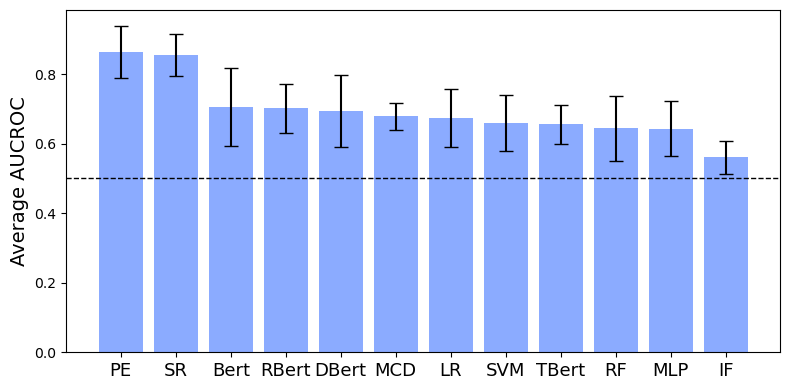

In [456]:
temp = res[~res['Dataset'].str.startswith('Base_Phi')]
temp = temp[temp['Size'] == temp['Max_Data_size']]
temp = temp[temp['Dataset'].isin(['Spam_text', 'SST2', 'Sentiment', 'AG_News', 'MNLI_Matched', 'Spam'])]

temp = temp[temp["Group"] != "other"]
temp = temp[temp["Group"] != "Dropout Agreement MV"]

temp["Group"] = temp["Group"].replace("Dropout Agreement DP", "MCD")
temp["Group"] = temp["Group"].replace("Softmax", "SR")

temp_df = temp.groupby("Group")["ROC_AUC"].agg(mean="mean", std="std").reset_index()
temp_df = temp_df.sort_values(by="mean", ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
x=np.arange(len(temp_df))
bars = ax.bar(
    x, temp_df["mean"], 
    yerr=temp_df["std"], 
    capsize=5, alpha=0.75, width=0.8, color="#648FFF", label="Average ROC"
)

ax.axhline(
    y=0.5,                 
    color='black',      
    linestyle='--',       
    linewidth=1 
)
ax.set_ylabel('Average AUCROC', fontsize=14)

ax.set_xticks(x)
ax.set_xticklabels(temp_df["Group"], rotation=0, ha='center', fontsize=13)

plt.tight_layout()
plt.savefig('exp3_softmax', dpi=300, bbox_inches='tight') 
plt.show()

In [457]:
temp_df

,Group,mean,std
6,PE,0.863102,0.074761
9,SR,0.855350,0.060769
0,Bert,0.706153,0.111446
7,RBert,0.701611,0.069335
1,DBert,0.694894,0.103215
4,MCD,0.678924,0.039622
3,LR,0.673729,0.084491
10,SVM,0.659481,0.080029
11,TBert,0.656143,0.056123
8,RF,0.644754,0.093327


In [459]:
groups = {
    'RF': ['Tf-Idf Embedding Random Forest', 'TinyBert Embedding Random Forest', 
           'Bert Embedding Random Forest', 'Distilbert Embedding Random Forest', 
           'RoBERTa Embedding Random Forest'],
    'SVM': ['Tf-Idf Embedding SVM', 'TinyBert Embedding SVM', 
            'Bert Embedding SVM', 'Distilbert Embedding SVM', 
            'RoBERTa Embedding SVM'],
    'MLP': ['Tf-Idf Embedding Simple NN', 'TinyBert Embedding Simple NN', 
           'Bert Embedding Simple NN', 'Distilbert Embedding Simple NN', 
           'RoBERTa Embedding Simple NN'],
    'LR': ['Tf-Idf Embedding Logistic Regression', 'TinyBert Embedding Logistic Regression', 
           'Bert Embedding Logistic Regression', 'Distilbert Embedding Logistic Regression', 
           'RoBERTa Embedding Logistic Regression'],
    'IF': ['Tf-Idf Outlier generic', 'TinyBert Outlier generic', 
                'Bert Outlier generic', 'Distilbert Outlier generic', 
                'RoBERTa Outlier generic'],
    'Bert': ['Bert Rejector generic'],
    'TBert': ['TinyBert Rejector generic'],
    'RBert': ['RoBERTa Rejector generic'],
    'DBert': ['Distilbert Rejector generic'],
    'PE-MLP': ['Base Embedding Simple NN'],
    'PE-LR': ['Base Embedding Logistic Regression'],
    'PE-RF': ['Base Embedding Random Forest'],
    'PE-SVM': ['Base Embedding SVM'],
    'PE-IF': ['Base Embedding Outlier generic']
}

data = []

for dataset, sizes in df_roc.items():
    for size, methods in sizes.items():
        for method, metrics in methods.items():
            data.append([dataset, size, method, metrics["roc_auc"]])

df_result = pd.DataFrame(data, columns=["Dataset", "Size", "Method", "ROC_AUC"])

df_result['Group'] = df_result['Method'].apply(classify)
max_data_size = df_result.groupby('Dataset')['Size'].max().reset_index()
max_data_size.rename(columns={'Size': 'Max_Data_size'}, inplace=True)
res = pd.merge(df_result, max_data_size, left_on=['Dataset', 'Size'], right_on=['Dataset', 'Max_Data_size'])

temp = res[~res['Dataset'].str.startswith('Base_Phi')]
temp = temp[temp['Size'] == temp['Max_Data_size']]
temp = temp[temp['Dataset'].isin(['Spam_text', 'SST2', 'Sentiment', 'AG_News', 'MNLI_Matched', 'Spam'])]

temp = temp[temp["Group"] != "other"]
temp = temp[temp["Group"] != "Dropout Agreement MV"]

temp["Group"] = temp["Group"].replace("Dropout Agreement DP", "MCD")
temp["Group"] = temp["Group"].replace("Softmax", "SR")

temp_df = temp.groupby("Group")["ROC_AUC"].agg(mean="mean", std="std").reset_index()
temp_df = temp_df.sort_values(by="mean", ascending=False)

temp_df['mean'] = temp_df['mean'].round(3)
temp_df['std'] = temp_df['std'].round(3)

temp_df

,Group,mean,std
7,PE-MLP,0.863,0.075
8,PE-RF,0.856,0.071
12,SR,0.855,0.061
6,PE-LR,0.836,0.081
9,PE-SVM,0.829,0.082
0,Bert,0.706,0.111
10,RBert,0.702,0.069
1,DBert,0.695,0.103
4,MCD,0.679,0.040
3,LR,0.674,0.084


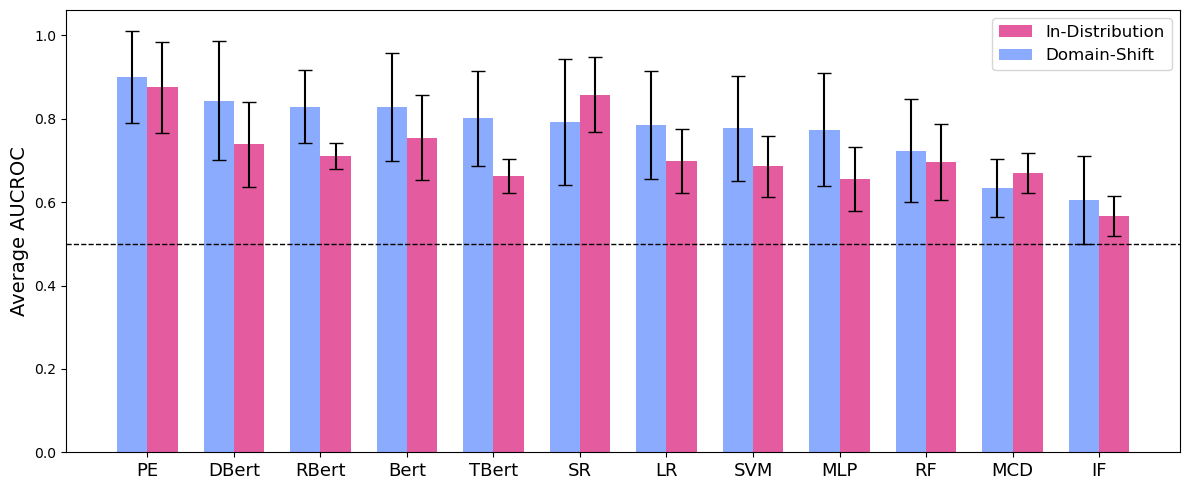

In [520]:
temp = res[~res['Dataset'].str.startswith('Base_Phi')]
temp = temp[temp['Size'] == temp['Max_Data_size']]
temp = temp[temp['Dataset'].isin(['Spam_text_OOD', 'Sentiment_OOD', 'Spam_OOD'])]
temp = temp[temp["Group"] != "other"]
temp = temp[temp["Group"] != "Dropout Agreement MV"]
temp["Group"] = temp["Group"].replace("Dropout Agreement DP", "MCD")

temp2 = res[~res['Dataset'].str.startswith('Base_Phi')]
temp2 = temp2[temp2['Size'] == temp2['Max_Data_size']]
temp2 = temp2[temp2['Dataset'].isin(['Spam_text', 'Sentiment', 'Spam'])]
temp2 = temp2[temp2["Group"] != "other"]
temp2 = temp2[temp2["Group"] != "Dropout Agreement MV"]
temp2["Group"] = temp2["Group"].replace("Dropout Agreement DP", "MCD")

temp_df = temp.groupby("Group")["ROC_AUC"].agg(mean="mean", std="std").reset_index()
temp_df = temp_df.sort_values(by="mean", ascending=False)
temp_df2 = temp2.groupby("Group")["ROC_AUC"].agg(mean="mean", std="std").reset_index()
temp_df2 = temp_df2.sort_values(by="mean", ascending=False)

merged_df = temp_df.merge(temp_df2, on="Group", how="inner")
merged_df = merged_df.sort_values(by="mean_x", ascending=False)

x = np.arange(len(merged_df)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(12, 5))

bars1 = ax.bar(
    x + width / 2, merged_df["mean_y"], 
    yerr=merged_df["std_y"], 
    capsize=5, alpha=0.75, width=width, color="#DC267F", label="In-Distribution"
)

bars2 = ax.bar(
    x - width / 2, merged_df["mean_x"], 
    yerr=merged_df["std_x"], 
    capsize=5, alpha=0.75, width=width, color="#648FFF", label="Domain-Shift"
)

ax.axhline(
    y=0.5,                 
    color='black',      
    linestyle='--',       
    linewidth=1 
)

ax.set_ylabel('Average AUCROC', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(merged_df['Group'], rotation=0, ha='center', fontsize=13)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('appendix_softmax_distribution_shift', dpi=300, bbox_inches='tight') 
plt.show()

In [525]:
merged_df['mean_x'] = merged_df['mean_x'].round(3)
merged_df['mean_y'] = merged_df['mean_y'].round(3)
merged_df['std_x'] = merged_df['std_x'].round(3)
merged_df['std_y'] = merged_df['std_y'].round(3)
merged_df

,Group,mean_x,std_x,mean_y,std_y
0,PE,0.900,0.110,0.875,0.110
1,DBert,0.843,0.142,0.739,0.102
2,RBert,0.830,0.087,0.710,0.031
3,Bert,0.828,0.130,0.755,0.101
4,TBert,0.801,0.113,0.663,0.040
5,SR,0.792,0.151,0.858,0.091
6,LR,0.785,0.130,0.699,0.076
7,SVM,0.778,0.126,0.686,0.073
8,MLP,0.774,0.136,0.656,0.076
9,RF,0.724,0.123,0.697,0.090


In [529]:
(0.739+0.710+0.755+0.663)/4

0.71675